In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv

In [2]:
load_dotenv()

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


In [4]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)



Output type: <class 'bytes'>
Output value: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00j\x00\x00\x00\xea\x08\x02\x00\x00\x00\xc5\xf3G\x18\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x16\xdeIDATx\x9c\xed\x9di`\x14E\xda\xc7k\xba\xe7>3\x99\x90c&\t\x99\\\x04\x92\x001`\xb2q\x97p\x04QN\x159\xc4\x97\x95\x85w\x05Y\x0e\x05\x17aQ\x16\xaf\xd5\x85E@\r\x88 \x04a\x05E1\x08\x08$"\xd9\xe5\\\x08\xd1\x84@ LNrg\x8ed\xee\xa3\x8f\xf7C\xfb\x86\xac\xce\x99\x9e!=\xb1\x7f\x9f&S\xd5=O\xff\xd3]U\xfd\xd4S\xf50p\x1c\x074}\x05\xeao\x03\x82\x1bZ>R\xd0\xf2\x91\x82\x96\x8f\x14\xb4|\xa4\xa0\xe5#\x05\x93\xe4\xf1\x06\xad\xa3[\xe30\x1bP\xb3\x1eE\x1c8\x86\x05\xc10\x88\xcd\x858<\x88/\x82\x05\x12f\x98\x9cC\xe6T\x8c\xbe\x8d\xfb4\xad\xb6\x9a\nS\xdd\r\x13\x9b\xcf\x008\x83/\x82\xf9b\x98\'`bh\x10\xc8\x07\xc1\xa0\xab\xd3a6\xa0\\>\xd4RkU\xa6\t\x12\xd2\x05\xd1\xc9\xfc>\x9c\xcag\xf9\x8c]\xc8\xa5\xe3j\x1c\x80\x900\x962]\x10\x1e\xcd\xed\xc3\xafR\x07\x83\xceQWi\xeah\xb2u\xb5;~3M\xa6H\xe0\xf9t\xb8o\xf2]+\xd2V^\xea\xce\x99\x166$S

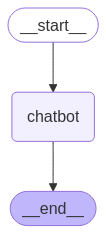

In [5]:
from IPython.display import Image, display

output = graph.get_graph().draw_mermaid_png()
print("Output type:", type(output))
print("Output value:", output)
display(Image(output))


In [7]:
config = {"configurable": {"thread_id": "1"}}


print(graph.invoke({"messages": [("user", "what happened in the 2024 olympics?")]}, config=config)['messages'][1].content)

I apologize, but since the 2024 Summer Olympics have not yet taken place, there is no information available on what happened during the event. The 2024 Summer Olympics are scheduled to take place in Paris, France, from July 26 to August 11, 2024.


In [8]:
print(next(memory.list(config)).checkpoint['channel_values']['messages'][-1].content)

I apologize, but since the 2024 Summer Olympics have not yet taken place, there is no information available on what happened during the event. The 2024 Summer Olympics are scheduled to take place in Paris, France, from July 26 to August 11, 2024.


### Chatbot with LangGraph (With Tools)

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv

load_dotenv()


True

In [10]:
# Tools to use
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

memory = MemorySaver()

In [11]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [14]:
# Instantiating the tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=1000)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=1000)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

tools = (arxiv_tool, wiki_tool)

llm_with_tools = llm.bind_tools(tools=tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools )
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph= graph_builder.compile()

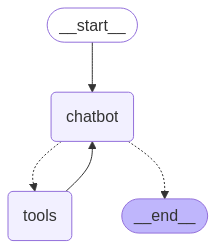

In [15]:
from IPython.display import Image, display

try:
    output = graph.get_graph().draw_mermaid_png()
    display(Image(output))
except Exception:
    pass

In [16]:
user_input = "what happened in the 2024 olympics?"

events= graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what happened in the 2024 olympics?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_t6p8)
 Call ID: call_t6p8
  Args:
    query: 2024 Summer Olympics
================================= Tool Message =================================
Name: wikipedia

Page: 2024 Summer Olympics
Summary: The 2024 Summer Olympics (French: Les Jeux Olympiques d'été de 2024), officially the Games of the XXXIII Olympiad (French: Jeux de la XXXIIIe olympiade de l'ère moderne) and branded as Paris 2024, were an international multi-sport event held from 26 July to 11 August 2024 in France, with several events started from 24 July. Paris was the host city, with events (mainly football) held in 16 additional cities spread across metropolitan France, including the sailing centre in the second-largest city of France, Marseille, on the Mediterranean Sea, as well as one subsite